In [1]:
from tqdm import tqdm
import matplotlib.pyplot as plt # type: module
import matplotlib.ticker as ticker
from matplotlib import colormaps
from matplotlib.colors import Normalize

import numpy as np
import os, glob
import time
import warnings

from rur.fortranfile import FortranFile
from rur import uri, uhmi, painter, drawer
from rur.sci.photometry import measure_luminosity
from rur.sci.geometry import get_angles, euler_angle
from rur.utool import rotate_data
from scipy.ndimage import gaussian_filter
uri.timer.verbose=1
# from rur.sci.kinematics import f_getpot

from icl_IO import mode2repo, pklsave, pklload
from icl_tool import *
from icl_numba import large_isin, large_isind, isin
from icl_draw import drawsnap, add_scalebar, addtext, MakeSub_nolabel, label_to_in, fancy_axis, circle
import argparse, subprocess
from importlib import reload
import cmasher as cmr
from copy import deepcopy
from multiprocessing import Pool, shared_memory

mode = 'nh'
iout = 1026
repo, rurmode, dp = mode2repo(mode)
snap = uri.RamsesSnapshot(repo, iout, mode=rurmode)
snaps = uri.TimeSeries(snap)
snaps.read_iout_avail()
nout = snaps.iout_avail['iout']
gals = uhmi.HaloMaker.load(snap, galaxy=True, double_precision=dp)
hals = uhmi.HaloMaker.load(snap, galaxy=False, double_precision=dp)
database = f"/home/jeon/MissingSat/database"

[Output 01026] Age (Gyr) : 11.624 / 13.741, z = 0.17149 (a = 0.8536)


In [2]:
LG = pklload(f"{database}/LG")

# Masses in Virial Radius

Do not remove this

In [3]:
# if(os.path.exists(f"{database}/00_LocalGroup_final_i_addvirmass.pickle")):
#     LG = pklload(f"{database}/00_LocalGroup_final_i_addvirmass.pickle")
# else:
#     for key in LG.keys():
#         subs = LG[key]['subs']

#         dtype1 = subs.dtype
#         dtype2 = [('mdm_vir','<f8'),('mstar_vir','<f8'),('mcell_vir','<f8'),('mcold_vir','<f8')]
#         dtype = np.dtype(dtype1.descr + dtype2)
#         newsubs = np.zeros(subs.shape, dtype=dtype)
#         for iname in dtype1.names:
#             newsubs[iname] = subs[iname]
        
#         for i, sub in enumerate(tqdm(subs)):
#             table = pklload(f"{database}/parts/insub/nh_dm_{key:04d}_{sub['id']:07d}.pickle")
#             if(len(table)>0):
#                 table = cut_sphere(table, sub['x'], sub['y'], sub['z'], sub['rvir'])
#                 if(len(table)>0):
#                     newsubs['mdm_vir'][i] = np.sum(table['m'])/snap.unit['Msol']
#             table = pklload(f"{database}/parts/insub/nh_star_{key:04d}_{sub['id']:07d}.pickle")
#             if(len(table)>0):
#                 table = cut_sphere(table, sub['x'], sub['y'], sub['z'], sub['rvir'])
#                 if(len(table)>0):
#                     newsubs['mstar_vir'][i] = np.sum(table['m'])/snap.unit['Msol']
#             table = pklload(f"{database}/parts/insub/nh_cell_{key:04d}_{sub['id']:07d}.pickle")
#             if(len(table)>0):
#                 table = uri.Cell( cut_sphere(table, sub['x'], sub['y'], sub['z'], sub['rvir']), snap )
#                 if(len(table)>0):
#                     newsubs['mcell_vir'][i] = np.sum(table['m'])/snap.unit['Msol']
#                     table = table[table['T','K'] < 2e4]
#                     if(len(table)>0):
#                         newsubs['mcold_vir'][i] = np.sum(table['m'])/snap.unit['Msol']
#         LG[key]['subs'] = newsubs
#     pklsave(LG, f"{database}/00_LocalGroup_final_i_addvirmass.pickle", overwrite=True)

In [84]:
allsubs = None
states = None
for key in LG.keys():
    subs = LG[key]['subs']
    real = LG[key]['real']
    dink = real[real['state']=='dink']['hid']
    ind = isin(subs['id'], dink)
    subs['dink'][ind] = True
    subs['dink'][~ind] = False
    state = np.zeros(len(subs), dtype='<U7')
    state[ind] = 'dink'
    state[~ind] = 'pair'
    upair = real[real['state']=='upair']['hid']
    ind = isin(subs['id'], upair)
    state[ind] = 'upair'

    allsubs = subs if allsubs is None else np.hstack((allsubs, subs))
    states = state if states is None else np.hstack((states, state))
argsort = np.argsort(allsubs['id'])
allsubs = allsubs[argsort]
states = states[argsort]
allsubs.dtype


dtype([('nparts', '<i4'), ('id', '<i4'), ('timestep', '<i4'), ('level', '<i4'), ('host', '<i4'), ('hostsub', '<i4'), ('nbsub', '<i4'), ('nextsub', '<i4'), ('aexp', '<f8'), ('m', '<f8'), ('x', '<f8'), ('y', '<f8'), ('z', '<f8'), ('vx', '<f8'), ('vy', '<f8'), ('vz', '<f8'), ('Lx', '<f8'), ('Ly', '<f8'), ('Lz', '<f8'), ('r', '<f8'), ('a', '<f8'), ('b', '<f8'), ('c', '<f8'), ('ek', '<f8'), ('ep', '<f8'), ('et', '<f8'), ('spin', '<f8'), ('sigma', '<f8'), ('rvir', '<f8'), ('mvir', '<f8'), ('tvir', '<f8'), ('cvel', '<f8'), ('rho0', '<f8'), ('rc', '<f8'), ('mcontam', '<f8'), ('r10_mem', '<f8'), ('r50_mem', '<f8'), ('r90_mem', '<f8'), ('r10_vir', '<f8'), ('r50_vir', '<f8'), ('r90_vir', '<f8'), ('r10_max', '<f8'), ('r50_max', '<f8'), ('r90_max', '<f8'), ('sub', '<i8'), ('dink', '?'), ('mdm', '<f8'), ('mstar', '<f8'), ('mcold', '<f8'), ('mcell', '<f8'), ('Host', '<i4'), ('r200kpc', '<f8'), ('m200', '<f8'), ('r200', '<f8'), ('mdm_vir', '<f8'), ('mstar_vir', '<f8'), ('mcell_vir', '<f8'), ('mcold_vi

# Using member parts?

Normalize by Rvir or R200 or Re? Or no norm but just using kpc?

In [85]:
fname = f"{database}/03_density_slope.pickle"
density_slope = None
if(os.path.exists(fname)):
    density_slope = pklload(fname)

In [86]:
def printdt(table):
    for iname in table.dtype.names:
        print(f"{iname:10s} {table[iname]}")

In [87]:
from scipy.optimize import curve_fit
def Nuker(logr_kpc, const, gamma):
    r_kpc = 10**logr_kpc
    A = (r_kpc/20)**gamma
    B = (0.5 + 0.5*r_kpc/20)**(-gamma-3)
    return np.log10( A * B ) + const
def chisq(obs, exp, weight, ddof=0):
    ssres = np.sum( (obs-exp)**2 * weight) / np.sum(weight)
    mean = np.mean(obs)
    sstot = np.sum( (obs-mean)**2 * weight) / np.sum(weight)
    return 1 - ssres/sstot

In [88]:
if(density_slope is None):
    denslops = np.zeros(len(allsubs))
    densloperrs = np.zeros(len(allsubs))
    draw=False
    for j, table in tqdm( enumerate(allsubs), total=len(allsubs)):
        memdm = uhmi.HaloMaker.read_member_part(snap, table['id'], galaxy=False, target_fields=['x','y','z','m'])
        mem_dist = distance(table, memdm)/snap.unit['kpc']; argsort = np.argsort(mem_dist)
        mem_dist = mem_dist[argsort]; mem_mass = memdm['m'][argsort]
        # minmax(mem_dist)
        leng = 20
        rbins = np.logspace(-1, 1.3, leng+1)
        rx = (rbins[1:] + rbins[:-1])/2
        rhos = np.zeros(leng)
        mass = np.zeros(leng)
        nparts = np.zeros(leng)
        for i in range(leng):
            mask = (mem_dist >= rbins[i]) & (mem_dist < rbins[i+1])
            nparts[i] = np.sum(mask)
            mass_in_sphere = np.sum(mem_mass[mask])/snap.unit['Msol']
            mass[i] = mass_in_sphere
            vol = sphere(rbins[i+1]) - sphere(rbins[i])
            rhos[i] = mass_in_sphere/vol # Msol/kpc^3


        mask = rhos>0
        rx = rx[mask]; rhos = rhos[mask]; mass = mass[mask]; nparts = nparts[mask]
        ws = 1/np.sqrt(nparts)
        rhoserr = rhos * ws
        ws /= np.sum(ws)
        try: popt, pcov = curve_fit(Nuker, np.log10(rx), np.log10(rhos), p0=[1, -2], bounds=([-np.inf, -3.5], [np.inf, 0.5]), sigma=ws, maxfev=5000, method='trf')
        except: popt = np.zeros(3)*np.nan; pcov = np.zeros(3)*np.nan
        chi = chisq(Nuker(np.log10(rx), *popt), np.log10(rhos), ws, ddof=2)

        denslops[j] = popt[-1]
        densloperrs[j] = np.sqrt(np.diag(pcov))[-1]

        if(draw):
            fig,ax = plt.subplots()
            color = 'k' if(table['dink']) else 'r'
            ax.errorbar(rx, rhos, yerr=rhoserr, ms=5, mec=color,mfc='none', fmt='o', ecolor=color, elinewidth=1, capsize=3, marker='s')
            ax.plot(rx, 10**Nuker(np.log10(rx), *popt), label=fr"[Nuker] $\gamma$={popt[-1]:.2f}$\pm${np.sqrt(np.diag(pcov))[-1]:.2f}, $R^2$={chi:.4f}", ls='-', lw=2, color='blue')
            ax.set_xscale('log')
            ax.set_yscale('log')

            ypos = 0.25
            ax.text(0.05, ypos, f"ID={table['id']}", ha='left', va='center', transform=ax.transAxes); ypos -= 0.05
            ax.text(0.05, ypos, f"logMh={np.log10(table['m']):.2f}", ha='left', va='center', transform=ax.transAxes); ypos -= 0.05
            ax.text(0.05, ypos, f"logMvir={np.log10(table['mvir']):.2f}", ha='left', va='center', transform=ax.transAxes); ypos -= 0.05
            ax.text(0.05, ypos, f"logM200={np.log10(table['m200']):.2f}", ha='left', va='center', transform=ax.transAxes); ypos -= 0.05
            ax.text(0.05, ypos, f"Rvir={table['rvir']/snap.unit['kpc']:.2f} kpc", ha='left', va='center', transform=ax.transAxes); ypos -= 0.05

            ax.legend()

            ax.set_xlabel(r'R [kpc]')
            ax.set_ylabel(r'$\rho$ [M$_\odot$ kpc$^{-3}$]')
            plt.show()
else:
    denslops = density_slope['slope_mem']
    densloperrs = density_slope['err_mem']

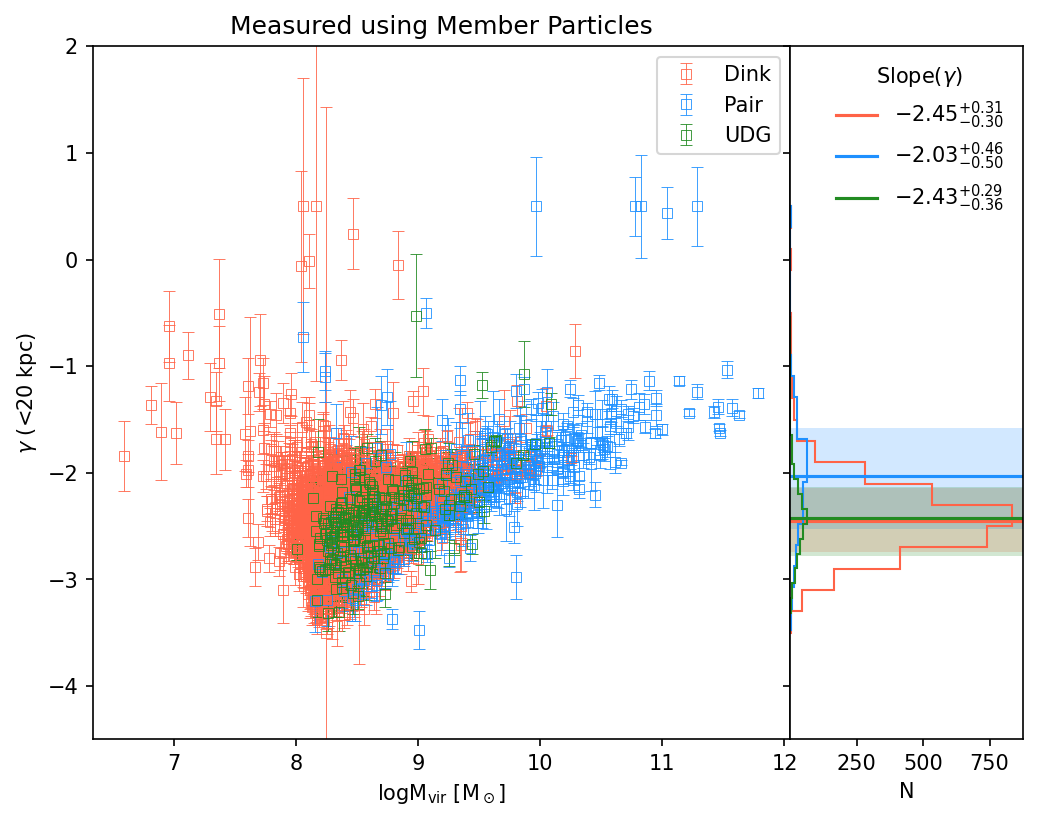

In [89]:
fig, axes = plt.subplots(ncols=2, figsize=(8,6), dpi=150, sharey=True, gridspec_kw={'width_ratios': [3, 1]})
ax = axes[0]
ax1 = axes[1]

# Dink
color='tomato'
mask = states=='dink'
sample = allsubs[mask]
slopes = denslops[mask]
errors = densloperrs[mask]

ax.errorbar(np.log10(sample['mvir']), slopes, yerr=errors, ms=5, mec=color,mfc='none', linewidth=0, ecolor=color, mew=0.4, elinewidth=0.4, capthick=0.4, capsize=3, marker='s', label='Dink')
ax1.hist(slopes, bins=20, orientation='horizontal', color=color, histtype='step')
q16,q50,q84 = np.percentile(slopes, q=[16,50,84])
ax1.axhline(q50, color=color, label=fr"${q50:.2f}_{{-{q50-q16:.2f}}}^{{+{q84-q50:.2f}}}$")
ax1.axhspan(q16,q84, ec='none', fc=color, alpha=0.2, zorder=-1)

# Pair
color='dodgerblue'
mask = states=='pair'
sample = allsubs[mask]
slopes = denslops[mask]
errors = densloperrs[mask]

ax.errorbar(np.log10(sample['mvir']), slopes, yerr=errors, ms=5, mec=color,mfc='none', linewidth=0, ecolor=color, mew=0.4, elinewidth=0.4, capthick=0.4, capsize=3, marker='s', label='Pair')
ax1.hist(slopes, bins=20, orientation='horizontal', color=color, histtype='step')
q16,q50,q84 = np.percentile(slopes, q=[16,50,84])
ax1.axhline(q50, color=color, label=fr"${q50:.2f}_{{-{q50-q16:.2f}}}^{{+{q84-q50:.2f}}}$")
ax1.axhspan(q16,q84, ec='none', fc=color, alpha=0.2, zorder=-1)

# UDG
color='forestgreen'
mask = states=='upair'
sample = allsubs[mask]
slopes = denslops[mask]
errors = densloperrs[mask]

ax.errorbar(np.log10(sample['mvir']), slopes, yerr=errors, ms=5, mec=color,mfc='none', linewidth=0, ecolor=color, mew=0.4, elinewidth=0.4, capthick=0.4, capsize=3, marker='s', label='UDG')
ax1.hist(slopes, bins=20, orientation='horizontal', color=color, histtype='step')
q16,q50,q84 = np.percentile(slopes, q=[16,50,84])
ax1.axhline(q50, color=color, label=fr"${q50:.2f}_{{-{q50-q16:.2f}}}^{{+{q84-q50:.2f}}}$")
ax1.axhspan(q16,q84, ec='none', fc=color, alpha=0.2, zorder=-1)

ax.legend()
ax1.legend(title=r'Slope($\gamma$)', frameon=False)
ax.set_xlabel(r'logM$_{\rm vir}$ [M$_\odot$]')
ax.set_ylabel(r'$\gamma$ (<20 kpc)')
ax1.set_xlabel(r'N')
ax1.set_xlim(0.001,)
ax.set_ylim(-4.5,2)
ax.set_title("Measured using Member Particles")
plt.subplots_adjust(wspace=0)
plt.savefig(f"{database}/photo/analysis/03_denslope_member.png", dpi=400, transparent=False, facecolor='white', bbox_inches='tight', pad_inches=0.1)
plt.show(); plt.close()

# In Rvir?

In [90]:
# density_slope = None
if(density_slope is None):
    denslops_vir = np.zeros(len(allsubs))
    densloperrs_vir = np.zeros(len(allsubs))
    draw=True
    np.random.shuffle(allsubs)
    for j, table in tqdm( enumerate(allsubs), total=len(allsubs)):
        memdm = pklload(f"{database}/parts/insub/nh_dm_{table['Host']:04d}_{table['id']:07d}.pickle")
        memdm = uri.Particle( cut_sphere(memdm, table['x'], table['y'], table['z'], table['rvir']),snap )
        # memdm = uhmi.HaloMaker.read_member_part(snap, table['id'], galaxy=False, target_fields=['x','y','z','m'])
        mem_dist = distance(table, memdm)/snap.unit['kpc']; argsort = np.argsort(mem_dist)
        mem_dist = mem_dist[argsort]; mem_mass = memdm['m'][argsort]
        # minmax(mem_dist)
        leng = 20
        rbins = np.logspace(-1, 1.3, leng+1)
        rx = (rbins[1:] + rbins[:-1])/2
        rhos = np.zeros(leng)
        mass = np.zeros(leng)
        nparts = np.zeros(leng)
        for i in range(leng):
            mask = (mem_dist >= rbins[i]) & (mem_dist < rbins[i+1])
            nparts[i] = np.sum(mask)
            mass_in_sphere = np.sum(mem_mass[mask])/snap.unit['Msol']
            mass[i] = mass_in_sphere
            vol = sphere(rbins[i+1]) - sphere(rbins[i])
            rhos[i] = mass_in_sphere/vol # Msol/kpc^3


        mask = rhos>0
        rx = rx[mask]; rhos = rhos[mask]; mass = mass[mask]; nparts = nparts[mask]
        ws = 1/np.sqrt(nparts)
        rhoserr = rhos * ws
        ws /= np.sum(ws)
        try: popt, pcov = curve_fit(Nuker, np.log10(rx), np.log10(rhos), p0=[1, -2], bounds=([-np.inf, -3.5], [np.inf, 0.5]), sigma=ws, maxfev=5000, method='trf')
        except: popt = np.zeros(3)*np.nan; pcov = np.zeros(3)*np.nan
        chi = chisq(Nuker(np.log10(rx), *popt), np.log10(rhos), ws, ddof=2)

        denslops_vir[j] = popt[-1]
        densloperrs_vir[j] = np.sqrt(np.diag(pcov))[-1]

        if(draw):
            fig,ax = plt.subplots(dpi=400)
            color = 'k' if(table['dink']) else 'r'
            ax.errorbar(rx, rhos, yerr=rhoserr, ms=5, mec=color,mfc='none', fmt='o', ecolor=color, elinewidth=1, capsize=3, marker='s')
            ax.plot(rx, 10**Nuker(np.log10(rx), *popt), label=fr"[Nuker] $\gamma$={popt[-1]:.2f}$\pm${np.sqrt(np.diag(pcov))[-1]:.2f}, $R^2$={chi:.4f}", ls='-', lw=2, color='blue')
            ax.set_xscale('log')
            ax.set_yscale('log')

            ypos = 0.25
            ax.text(0.05, ypos, f"ID={table['id']}", ha='left', va='center', transform=ax.transAxes); ypos -= 0.05
            ax.text(0.05, ypos, f"logMh={np.log10(table['m']):.2f}", ha='left', va='center', transform=ax.transAxes); ypos -= 0.05
            ax.text(0.05, ypos, f"logMvir={np.log10(table['mvir']):.2f}", ha='left', va='center', transform=ax.transAxes); ypos -= 0.05
            ax.text(0.05, ypos, f"logM200={np.log10(table['m200']):.2f}", ha='left', va='center', transform=ax.transAxes); ypos -= 0.05
            ax.text(0.05, ypos, f"Rvir={table['rvir']/snap.unit['kpc']:.2f} kpc", ha='left', va='center', transform=ax.transAxes); ypos -= 0.05

            ax.legend()

            ax.set_xlabel(r'R [kpc]')
            ax.set_ylabel(r'$\rho$ [M$_\odot$ kpc$^{-3}$]')
            plt.show()
            stop()
else:
    denslops_vir = density_slope['slope_vir']
    densloperrs_vir = density_slope['err_vir']

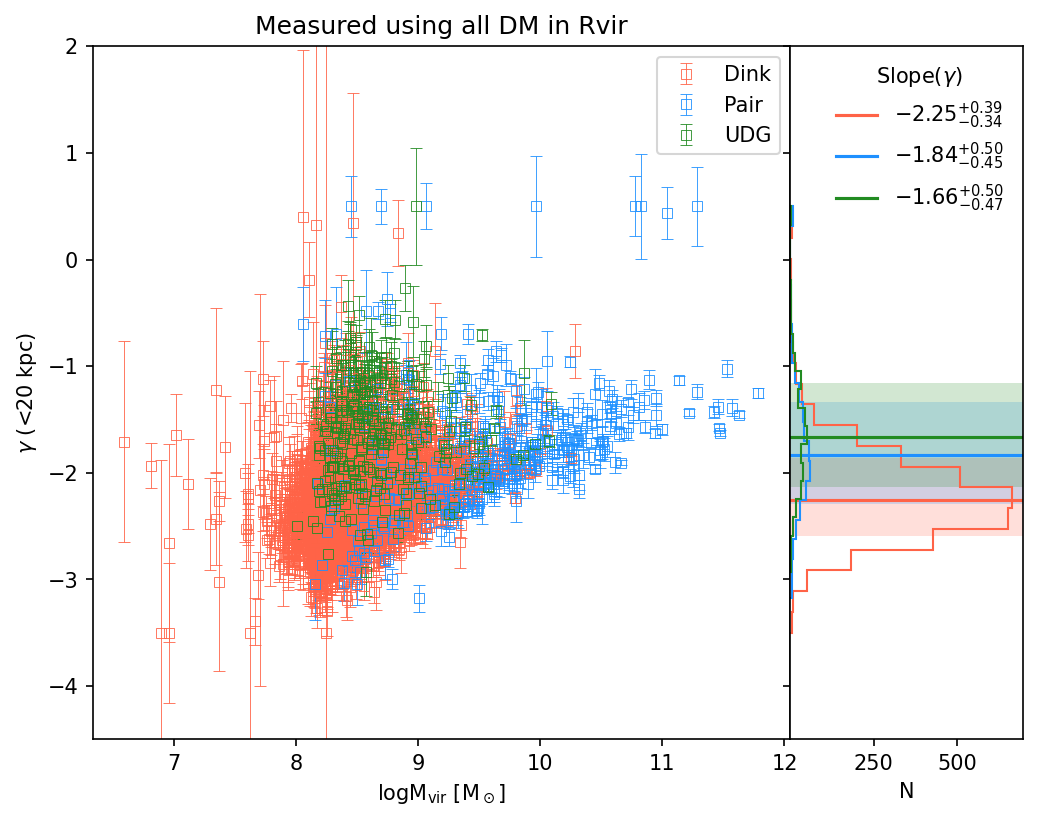

In [91]:
fig, axes = plt.subplots(ncols=2, figsize=(8,6), dpi=150, sharey=True, gridspec_kw={'width_ratios': [3, 1]})
ax = axes[0]
ax1 = axes[1]

# Dink
color='tomato'
mask = states=='dink'
sample = allsubs[mask]
slopes = denslops_vir[mask]
errors = densloperrs_vir[mask]

ax.errorbar(np.log10(sample['mvir']), slopes, yerr=errors, ms=5, mec=color,mfc='none', linewidth=0, ecolor=color, mew=0.4, elinewidth=0.4, capthick=0.4, capsize=3, marker='s', label='Dink')
ax1.hist(slopes, bins=20, orientation='horizontal', color=color, histtype='step')
q16,q50,q84 = np.percentile(slopes, q=[16,50,84])
ax1.axhline(q50, color=color, label=fr"${q50:.2f}_{{-{q50-q16:.2f}}}^{{+{q84-q50:.2f}}}$")
ax1.axhspan(q16,q84, ec='none', fc=color, alpha=0.2, zorder=-1)

# Pair
color='dodgerblue'
mask = states=='pair'
sample = allsubs[mask]
slopes = denslops_vir[mask]
errors = densloperrs_vir[mask]

ax.errorbar(np.log10(sample['mvir']), slopes, yerr=errors, ms=5, mec=color,mfc='none', linewidth=0, ecolor=color, mew=0.4, elinewidth=0.4, capthick=0.4, capsize=3, marker='s', label='Pair')
ax1.hist(slopes, bins=20, orientation='horizontal', color=color, histtype='step')
q16,q50,q84 = np.percentile(slopes, q=[16,50,84])
ax1.axhline(q50, color=color, label=fr"${q50:.2f}_{{-{q50-q16:.2f}}}^{{+{q84-q50:.2f}}}$")
ax1.axhspan(q16,q84, ec='none', fc=color, alpha=0.2, zorder=-1)

# UDG
color='forestgreen'
mask = states=='upair'
sample = allsubs[mask]
slopes = denslops_vir[mask]
errors = densloperrs_vir[mask]

ax.errorbar(np.log10(sample['mvir']), slopes, yerr=errors, ms=5, mec=color,mfc='none', linewidth=0, ecolor=color, mew=0.4, elinewidth=0.4, capthick=0.4, capsize=3, marker='s', label='UDG')
ax1.hist(slopes, bins=20, orientation='horizontal', color=color, histtype='step')
q16,q50,q84 = np.percentile(slopes, q=[16,50,84])
ax1.axhline(q50, color=color, label=fr"${q50:.2f}_{{-{q50-q16:.2f}}}^{{+{q84-q50:.2f}}}$")
ax1.axhspan(q16,q84, ec='none', fc=color, alpha=0.2, zorder=-1)

ax.legend()
ax1.legend(title=r'Slope($\gamma$)', frameon=False)
ax.set_xlabel(r'logM$_{\rm vir}$ [M$_\odot$]')
ax.set_ylabel(r'$\gamma$ (<20 kpc)')
ax1.set_xlabel(r'N')
ax1.set_xlim(0.001,)
ax.set_ylim(-4.5,2)
ax.set_title("Measured using all DM in Rvir")
plt.subplots_adjust(wspace=0)
plt.savefig(f"{database}/photo/analysis/03_denslope_rvir.png", dpi=400, transparent=False, facecolor='white', bbox_inches='tight', pad_inches=0.1)
plt.show(); plt.close()

## all particles and cells?

In [92]:
if(density_slope is None):
    denslops_tot = np.zeros(len(allsubs))
    densloperrs_tot = np.zeros(len(allsubs))
    draw=False
    for j, table in tqdm( enumerate(allsubs), total=len(allsubs)):
        memdm = pklload(f"{database}/parts/insub/nh_dm_{table['Host']:04d}_{table['id']:07d}.pickle")
        memdm = cut_sphere(memdm, table['x'], table['y'], table['z'], table['rvir'])
        memstar = pklload(f"{database}/parts/insub/nh_star_{table['Host']:04d}_{table['id']:07d}.pickle")
        memstar = cut_sphere(memstar, table['x'], table['y'], table['z'], table['rvir'])
        memcell = pklload(f"{database}/parts/insub/nh_cell_{table['Host']:04d}_{table['id']:07d}.pickle")
        memcell = uri.Cell(cut_sphere(memcell, table['x'], table['y'], table['z'], table['rvir']),snap)
        dist1 = distance(table, memdm)/snap.unit['kpc']; mass1 = memdm['m']
        dist2 = distance(table, memstar)/snap.unit['kpc']; mass2 = memstar['m']
        dist3 = distance(table, memcell)/snap.unit['kpc']; mass3 = memcell['m']
        mem_dist = np.hstack((dist1, dist2, dist3)); mem_mass = np.hstack((mass1, mass2, mass3))
        argsort = np.argsort(mem_dist)
        mem_dist = mem_dist[argsort]; mem_mass = mem_mass[argsort]

        leng = 20
        rbins = np.logspace(-1, 1.3, leng+1)
        rx = (rbins[1:] + rbins[:-1])/2
        rhos = np.zeros(leng)
        mass = np.zeros(leng)
        nparts = np.zeros(leng)
        for i in range(leng):
            mask = (mem_dist >= rbins[i]) & (mem_dist < rbins[i+1])
            nparts[i] = np.sum(mask)
            mass_in_sphere = np.sum(mem_mass[mask])/snap.unit['Msol']
            mass[i] = mass_in_sphere
            vol = sphere(rbins[i+1]) - sphere(rbins[i])
            rhos[i] = mass_in_sphere/vol # Msol/kpc^3


        mask = rhos>0
        rx = rx[mask]; rhos = rhos[mask]; mass = mass[mask]; nparts = nparts[mask]
        ws = 1/np.sqrt(nparts)
        rhoserr = rhos * ws
        ws /= np.sum(ws)
        try: popt, pcov = curve_fit(Nuker, np.log10(rx), np.log10(rhos), p0=[1, -2], bounds=([-np.inf, -3.5], [np.inf, 0.5]), sigma=ws, maxfev=5000, method='trf')
        except: popt = np.zeros(3)*np.nan; pcov = np.zeros(3)*np.nan
        chi = chisq(Nuker(np.log10(rx), *popt), np.log10(rhos), ws, ddof=2)

        denslops_tot[j] = popt[-1]
        densloperrs_tot[j] = np.sqrt(np.diag(pcov))[-1]

        if(draw):
            fig,ax = plt.subplots()
            color = 'k' if(table['dink']) else 'r'
            ax.errorbar(rx, rhos, yerr=rhoserr, ms=5, mec=color,mfc='none', fmt='o', ecolor=color, elinewidth=1, capsize=3, marker='s')
            ax.plot(rx, 10**Nuker(np.log10(rx), *popt), label=fr"[Nuker] $\gamma$={popt[-1]:.2f}$\pm${np.sqrt(np.diag(pcov))[-1]:.2f}, $R^2$={chi:.4f}", ls='-', lw=2, color='blue')
            ax.set_xscale('log')
            ax.set_yscale('log')

            ypos = 0.25
            ax.text(0.05, ypos, f"ID={table['id']}", ha='left', va='center', transform=ax.transAxes); ypos -= 0.05
            ax.text(0.05, ypos, f"logMh={np.log10(table['m']):.2f}", ha='left', va='center', transform=ax.transAxes); ypos -= 0.05
            ax.text(0.05, ypos, f"logMvir={np.log10(table['mvir']):.2f}", ha='left', va='center', transform=ax.transAxes); ypos -= 0.05
            ax.text(0.05, ypos, f"logM200={np.log10(table['m200']):.2f}", ha='left', va='center', transform=ax.transAxes); ypos -= 0.05
            ax.text(0.05, ypos, f"Rvir={table['rvir']/snap.unit['kpc']:.2f} kpc", ha='left', va='center', transform=ax.transAxes); ypos -= 0.05

            ax.legend()

            ax.set_xlabel(r'R [kpc]')
            ax.set_ylabel(r'$\rho$ [M$_\odot$ kpc$^{-3}$]')
            plt.show()
else:
    denslops_tot = density_slope['slope_tot']
    densloperrs_tot = density_slope['err_tot']

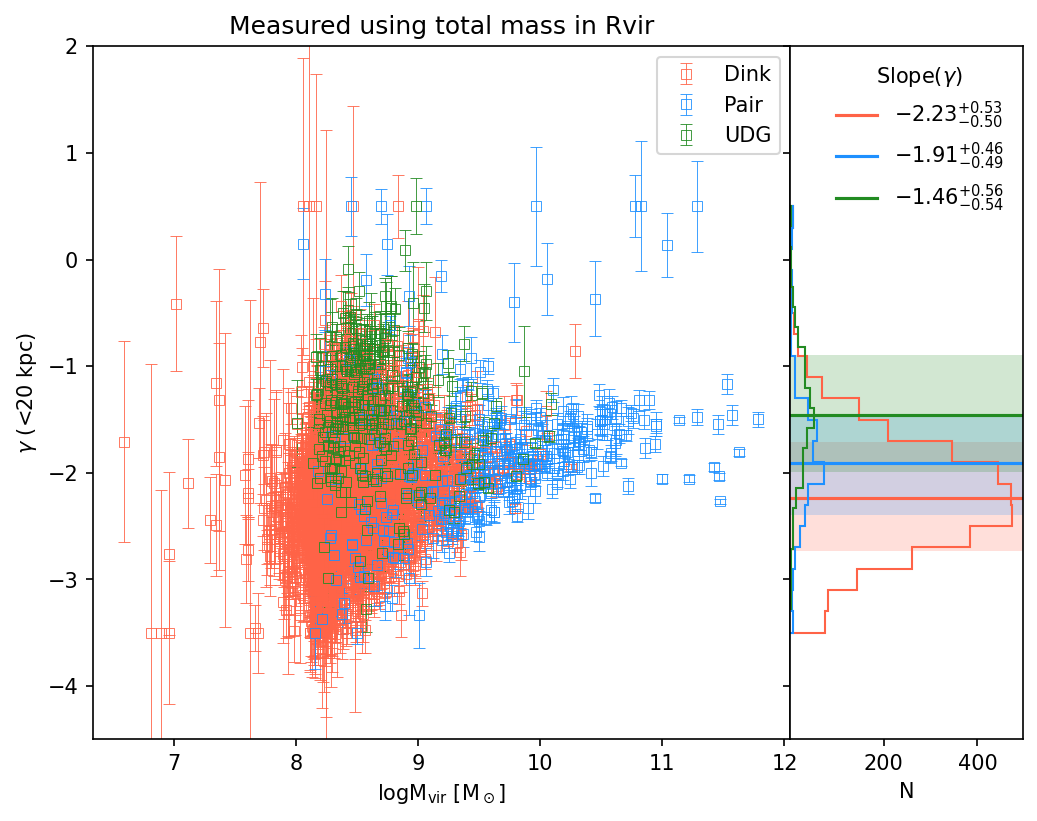

In [93]:
fig, axes = plt.subplots(ncols=2, figsize=(8,6), dpi=150, sharey=True, gridspec_kw={'width_ratios': [3, 1]})
ax = axes[0]
ax1 = axes[1]

# Dink
color='tomato'
mask = states=='dink'
sample = allsubs[mask]
slopes = denslops_tot[mask]
errors = densloperrs_tot[mask]

ax.errorbar(np.log10(sample['mvir']), slopes, yerr=errors, ms=5, mec=color,mfc='none', linewidth=0, ecolor=color, mew=0.4, elinewidth=0.4, capthick=0.4, capsize=3, marker='s', label='Dink')
ax1.hist(slopes, bins=20, orientation='horizontal', color=color, histtype='step')
q16,q50,q84 = np.percentile(slopes, q=[16,50,84])
ax1.axhline(q50, color=color, label=fr"${q50:.2f}_{{-{q50-q16:.2f}}}^{{+{q84-q50:.2f}}}$")
ax1.axhspan(q16,q84, ec='none', fc=color, alpha=0.2, zorder=-1)

# Pair
color='dodgerblue'
mask = states=='pair'
sample = allsubs[mask]
slopes = denslops_tot[mask]
errors = densloperrs_tot[mask]

ax.errorbar(np.log10(sample['mvir']), slopes, yerr=errors, ms=5, mec=color,mfc='none', linewidth=0, ecolor=color, mew=0.4, elinewidth=0.4, capthick=0.4, capsize=3, marker='s', label='Pair')
ax1.hist(slopes, bins=20, orientation='horizontal', color=color, histtype='step')
q16,q50,q84 = np.percentile(slopes, q=[16,50,84])
ax1.axhline(q50, color=color, label=fr"${q50:.2f}_{{-{q50-q16:.2f}}}^{{+{q84-q50:.2f}}}$")
ax1.axhspan(q16,q84, ec='none', fc=color, alpha=0.2, zorder=-1)

# UDG
color='forestgreen'
mask = states=='upair'
sample = allsubs[mask]
slopes = denslops_tot[mask]
errors = densloperrs_tot[mask]

ax.errorbar(np.log10(sample['mvir']), slopes, yerr=errors, ms=5, mec=color,mfc='none', linewidth=0, ecolor=color, mew=0.4, elinewidth=0.4, capthick=0.4, capsize=3, marker='s', label='UDG')
ax1.hist(slopes, bins=20, orientation='horizontal', color=color, histtype='step')
q16,q50,q84 = np.percentile(slopes, q=[16,50,84])
ax1.axhline(q50, color=color, label=fr"${q50:.2f}_{{-{q50-q16:.2f}}}^{{+{q84-q50:.2f}}}$")
ax1.axhspan(q16,q84, ec='none', fc=color, alpha=0.2, zorder=-1)

ax.legend()
ax1.legend(title=r'Slope($\gamma$)', frameon=False)
ax.set_xlabel(r'logM$_{\rm vir}$ [M$_\odot$]')
ax.set_ylabel(r'$\gamma$ (<20 kpc)')
ax1.set_xlabel(r'N')
ax1.set_xlim(0.001,)
ax.set_ylim(-4.5,2)
ax.set_title("Measured using total mass in Rvir")
plt.subplots_adjust(wspace=0)
plt.savefig(f"{database}/photo/analysis/03_denslope_all.png", dpi=400, transparent=False, facecolor='white', bbox_inches='tight', pad_inches=0.1)
plt.show(); plt.close()

In [94]:
if(density_slope is None):
    dtype = [('subid','<i4'),('slope_mem','<f8'),('err_mem','<f8'),('slope_vir','<f8'),('err_vir','<f8'),('slope_tot','<f8'),('err_tot','<f8')]
    density_slope = np.zeros(len(allsubs), dtype=dtype)
    density_slope['subid'] = allsubs['id']
    density_slope['slope_mem'] = denslops
    density_slope['err_mem'] = densloperrs
    density_slope['slope_vir'] = denslops_vir
    density_slope['err_vir'] = densloperrs_vir
    density_slope['slope_tot'] = denslops_tot
    density_slope['err_tot'] = densloperrs_tot
    pklsave(density_slope, f"{database}/03_density_slope.pickle", overwrite=True)

# Size Mass

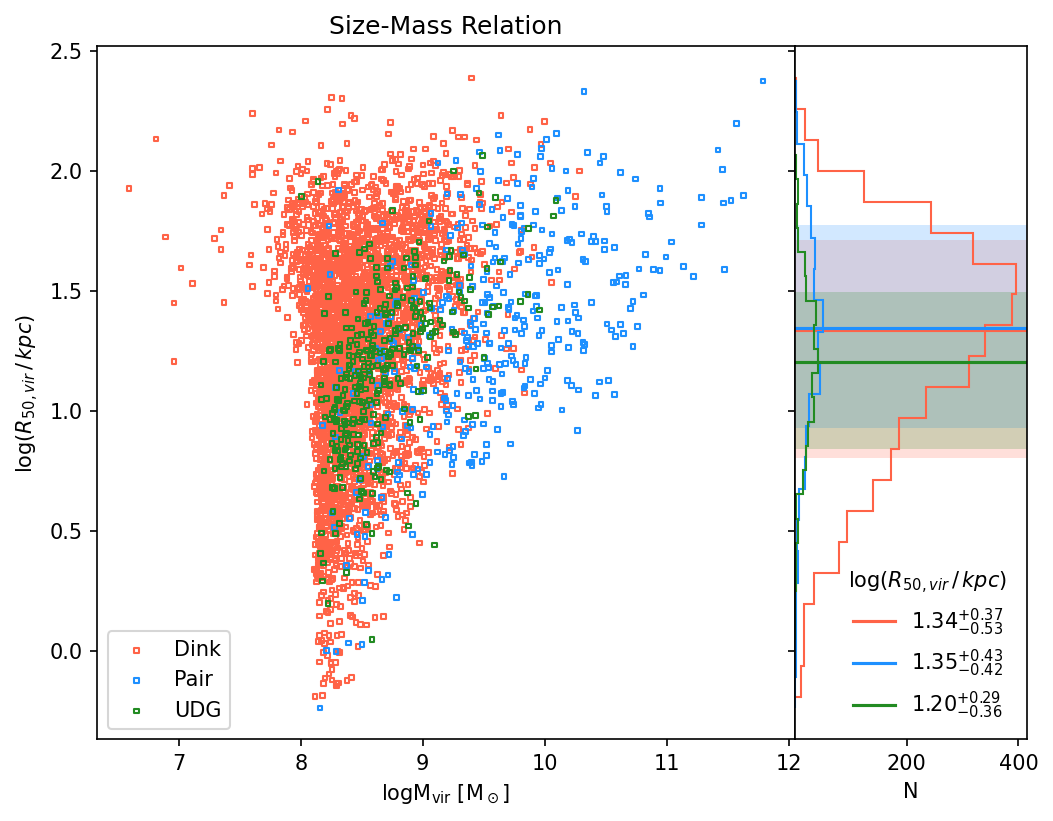

In [95]:
fig, axes = plt.subplots(ncols=2, figsize=(8,6), dpi=150, sharey=True, gridspec_kw={'width_ratios': [3, 1]})
ax = axes[0]
ax1 = axes[1]

# Dink
color='tomato'
mask = states=='dink'
sample = allsubs[mask]
val = np.log10( sample['r50_vir']/snap.unit['kpc'] )

ax.scatter(np.log10(sample['mvir']), val, s=5, ec=color,fc='none', label='Dink', marker='s')
ax1.hist(val, bins=20, orientation='horizontal', color=color, histtype='step')
q16,q50,q84 = np.percentile(val, q=[16,50,84])
ax1.axhline(q50, color=color, label=fr"${q50:.2f}_{{-{q50-q16:.2f}}}^{{+{q84-q50:.2f}}}$")
ax1.axhspan(q16,q84, ec='none', fc=color, alpha=0.2, zorder=-1)

# Pair
color='dodgerblue'
mask = states=='pair'
sample = allsubs[mask]
val = np.log10( sample['r50_vir']/snap.unit['kpc'] )

ax.scatter(np.log10(sample['mvir']), val, s=5, ec=color,fc='none', label='Pair', marker='s')
ax1.hist(val, bins=20, orientation='horizontal', color=color, histtype='step')
q16,q50,q84 = np.percentile(val, q=[16,50,84])
ax1.axhline(q50, color=color, label=fr"${q50:.2f}_{{-{q50-q16:.2f}}}^{{+{q84-q50:.2f}}}$")
ax1.axhspan(q16,q84, ec='none', fc=color, alpha=0.2, zorder=-1)

# UDG
color='forestgreen'
mask = states=='upair'
sample = allsubs[mask]
val = np.log10( sample['r50_vir']/snap.unit['kpc'] )

ax.scatter(np.log10(sample['mvir']), val, s=5, ec=color,fc='none', label='UDG', marker='s')
ax1.hist(val, bins=20, orientation='horizontal', color=color, histtype='step')
q16,q50,q84 = np.percentile(val, q=[16,50,84])
ax1.axhline(q50, color=color, label=fr"${q50:.2f}_{{-{q50-q16:.2f}}}^{{+{q84-q50:.2f}}}$")
ax1.axhspan(q16,q84, ec='none', fc=color, alpha=0.2, zorder=-1)

ax.legend()
ax1.legend(title=r'log$(R_{50,vir}\,/\,kpc)$ ', frameon=False)
ax.set_xlabel(r'logM$_{\rm vir}$ [M$_\odot$]')
ax.set_ylabel(r'log$(R_{50,vir}\,/\,kpc)$ ')
ax1.set_xlabel(r'N')
ax1.set_xlim(0.001,)
ax.set_title("Size-Mass Relation")
plt.subplots_adjust(wspace=0)
plt.savefig(f"{database}/photo/analysis/03_size_mass.png", dpi=400, transparent=False, facecolor='white', bbox_inches='tight', pad_inches=0.1)
plt.show(); plt.close()

No special..

# Stellar Fraction

/tmp/ipykernel_24952/4117083626.py:9: RuntimeWarning: divide by zero encountered in log10
  val = np.log10( sample['mstar_vir']/sample['mdm_vir'] )


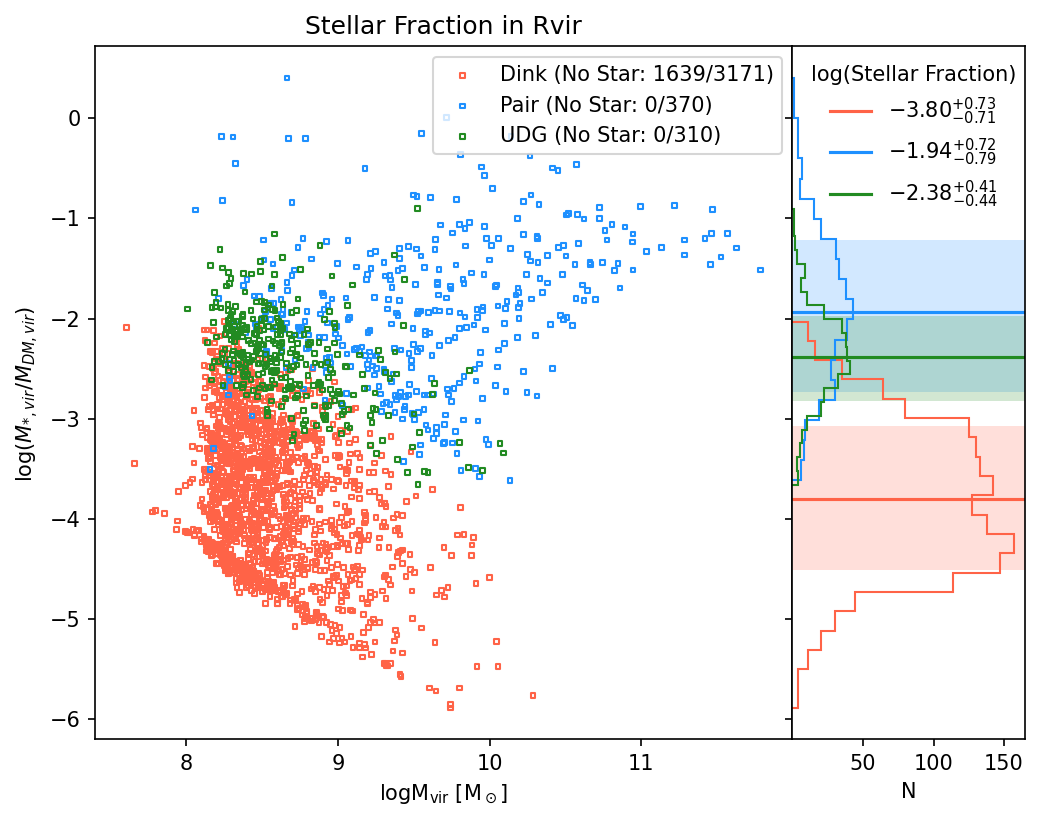

In [97]:
fig, axes = plt.subplots(ncols=2, figsize=(8,6), dpi=150, sharey=True, gridspec_kw={'width_ratios': [3, 1]})
ax = axes[0]
ax1 = axes[1]

# Dink
color='tomato'
mask = states=='dink'
sample = allsubs[mask]
val = np.log10( sample['mstar_vir']/sample['mdm_vir'] )
mask = np.isfinite(val)
val = val[mask]; sample = sample[mask]

ax.scatter(np.log10(sample['mvir']), val, s=5, ec=color,fc='none', label=f'Dink (No Star: {np.sum(~mask)}/{len(mask)})', marker='s')
ax1.hist(val, bins=20, orientation='horizontal', color=color, histtype='step')
q16,q50,q84 = np.percentile(val, q=[16,50,84])
ax1.axhline(q50, color=color, label=fr"${q50:.2f}_{{-{q50-q16:.2f}}}^{{+{q84-q50:.2f}}}$")
ax1.axhspan(q16,q84, ec='none', fc=color, alpha=0.2, zorder=-1)

# Pair
color='dodgerblue'
mask = states=='pair'
sample = allsubs[mask]
val = np.log10( sample['mstar_vir']/sample['mdm_vir'] )
mask = np.isfinite(val)
val = val[mask]; sample = sample[mask]

ax.scatter(np.log10(sample['mvir']), val, s=5, ec=color,fc='none', label=f'Pair (No Star: {np.sum(~mask)}/{len(mask)})', marker='s')
ax1.hist(val, bins=20, orientation='horizontal', color=color, histtype='step')
q16,q50,q84 = np.percentile(val, q=[16,50,84])
ax1.axhline(q50, color=color, label=fr"${q50:.2f}_{{-{q50-q16:.2f}}}^{{+{q84-q50:.2f}}}$")
ax1.axhspan(q16,q84, ec='none', fc=color, alpha=0.2, zorder=-1)

# UDG
color='forestgreen'
mask = states=='upair'
sample = allsubs[mask]
val = np.log10( sample['mstar_vir']/sample['mdm_vir'] )
mask = np.isfinite(val)
val = val[mask]; sample = sample[mask]

ax.scatter(np.log10(sample['mvir']), val, s=5, ec=color,fc='none', label=f'UDG (No Star: {np.sum(~mask)}/{len(mask)})', marker='s')
ax1.hist(val, bins=20, orientation='horizontal', color=color, histtype='step')
q16,q50,q84 = np.percentile(val, q=[16,50,84])
ax1.axhline(q50, color=color, label=fr"${q50:.2f}_{{-{q50-q16:.2f}}}^{{+{q84-q50:.2f}}}$")
ax1.axhspan(q16,q84, ec='none', fc=color, alpha=0.2, zorder=-1)

ax.legend()
ax1.legend(title=r'log(Stellar Fraction)', frameon=False)
ax.set_xlabel(r'logM$_{\rm vir}$ [M$_\odot$]')
ax.set_ylabel(r'log$(M_{*,vir}/M_{DM,vir})$ ')
ax1.set_xlabel(r'N')
ax1.set_xlim(0.001,)
ax.set_title("Stellar Fraction in Rvir")
plt.subplots_adjust(wspace=0)
plt.savefig(f"{database}/photo/analysis/03_stellar fraction.png", dpi=400, transparent=False, facecolor='white', bbox_inches='tight', pad_inches=0.1)
plt.show(); plt.close()

No special.. But some dinks have too much stellar fraction?

# Angular Momentum

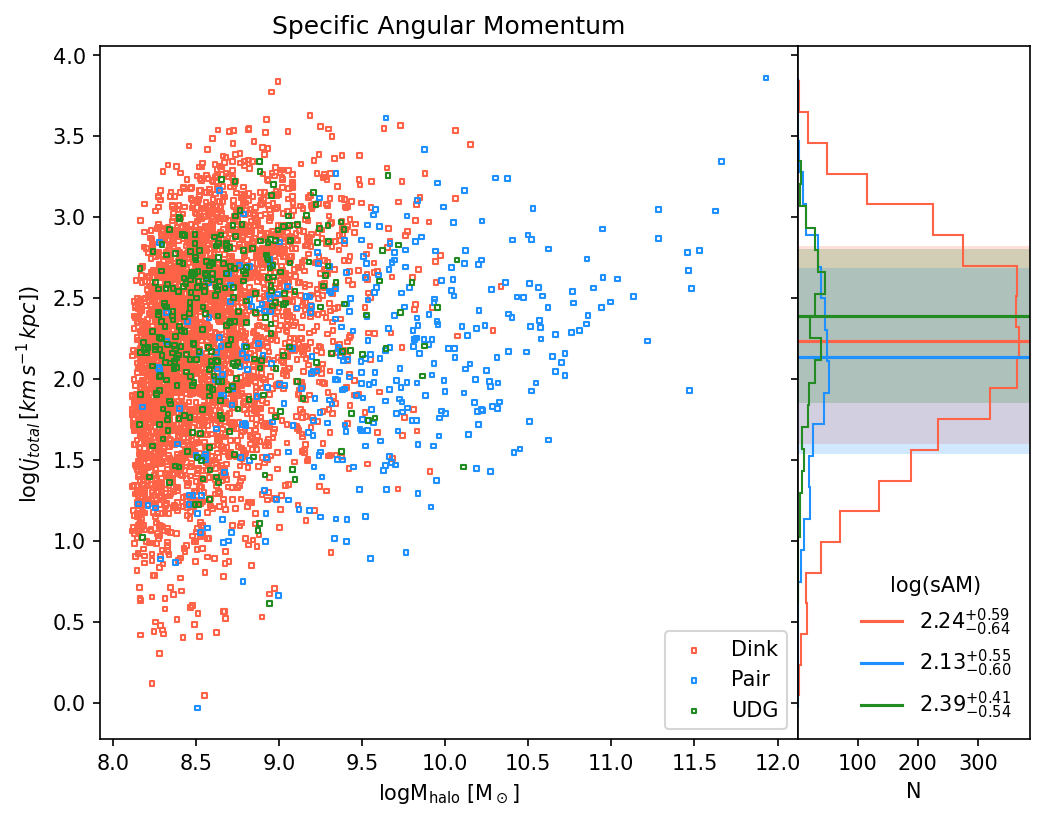

In [98]:
fig, axes = plt.subplots(ncols=2, figsize=(8,6), dpi=150, sharey=True, gridspec_kw={'width_ratios': [3, 1]})
ax = axes[0]
ax1 = axes[1]

# Dink
color='tomato'
mask = states=='dink'
sample = allsubs[mask]
val = np.log10(np.sqrt( sample['Lx']**2 + sample['Ly']**2 + sample['Lz']**2 ) / sample['m'])+3
# mask = np.isfinite(val)
# val = val[mask]; sample = sample[mask]

ax.scatter(np.log10(sample['m']), val, s=5, ec=color,fc='none', label='Dink', marker='s')
ax1.hist(val, bins=20, orientation='horizontal', color=color, histtype='step')
q16,q50,q84 = np.percentile(val, q=[16,50,84])
ax1.axhline(q50, color=color, label=fr"${q50:.2f}_{{-{q50-q16:.2f}}}^{{+{q84-q50:.2f}}}$")
ax1.axhspan(q16,q84, ec='none', fc=color, alpha=0.2, zorder=-1)

# Pair
color='dodgerblue'
mask = states=='pair'
sample = allsubs[mask]
val = np.log10(np.sqrt( sample['Lx']**2 + sample['Ly']**2 + sample['Lz']**2 ) / sample['m'])+3
# mask = np.isfinite(val)
# val = val[mask]; sample = sample[mask]

ax.scatter(np.log10(sample['m']), val, s=5, ec=color,fc='none', label='Pair', marker='s')
ax1.hist(val, bins=20, orientation='horizontal', color=color, histtype='step')
q16,q50,q84 = np.percentile(val, q=[16,50,84])
ax1.axhline(q50, color=color, label=fr"${q50:.2f}_{{-{q50-q16:.2f}}}^{{+{q84-q50:.2f}}}$")
ax1.axhspan(q16,q84, ec='none', fc=color, alpha=0.2, zorder=-1)

# UDG
color='forestgreen'
mask = states=='upair'
sample = allsubs[mask]
val = np.log10(np.sqrt( sample['Lx']**2 + sample['Ly']**2 + sample['Lz']**2 ) / sample['m'])+3
# mask = np.isfinite(val)
# val = val[mask]; sample = sample[mask]

ax.scatter(np.log10(sample['m']), val, s=5, ec=color,fc='none', label='UDG', marker='s')
ax1.hist(val, bins=20, orientation='horizontal', color=color, histtype='step')
q16,q50,q84 = np.percentile(val, q=[16,50,84])
ax1.axhline(q50, color=color, label=fr"${q50:.2f}_{{-{q50-q16:.2f}}}^{{+{q84-q50:.2f}}}$")
ax1.axhspan(q16,q84, ec='none', fc=color, alpha=0.2, zorder=-1)

ax.legend()
ax1.legend(title=r'log(sAM)', frameon=False)
ax.set_xlabel(r'logM$_{\rm halo}$ [M$_\odot$]')
ax.set_ylabel(r'log$(j_{total}\,[km\,s^{-1}\,kpc])$ ')
ax1.set_xlabel(r'N')
ax1.set_xlim(0.001,)
ax.set_title("Specific Angular Momentum") #km/s * Mpc
plt.subplots_adjust(wspace=0)
plt.savefig(f"{database}/photo/analysis/03_ang_mom.png", dpi=400, transparent=False, facecolor='white', bbox_inches='tight', pad_inches=0.1)
plt.show(); plt.close()

# Contamination

/tmp/ipykernel_24952/42585810.py:9: RuntimeWarning: divide by zero encountered in log10
  val = np.log10( sample['mcontam']/sample['m'] )
/tmp/ipykernel_24952/42585810.py:24: RuntimeWarning: divide by zero encountered in log10
  val = np.log10( sample['mcontam']/sample['m'] )
/tmp/ipykernel_24952/42585810.py:39: RuntimeWarning: divide by zero encountered in log10
  val = np.log10( sample['mcontam']/sample['m'] )


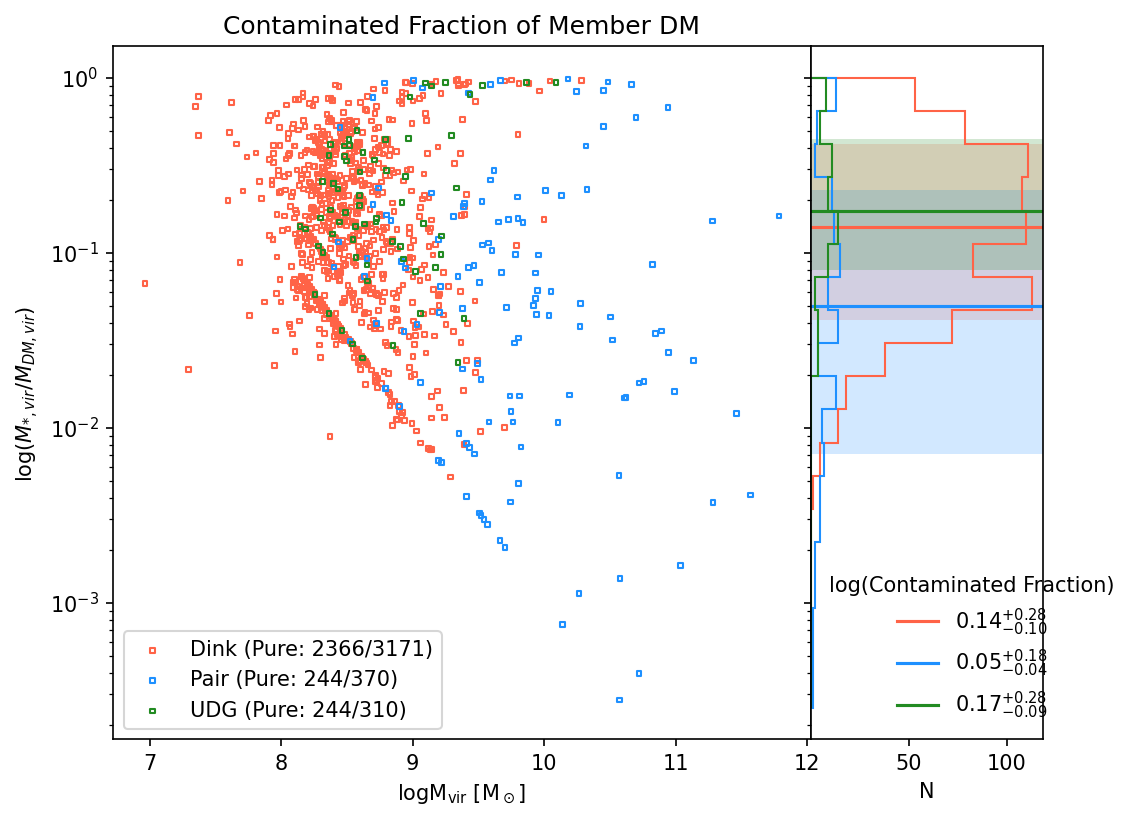

In [99]:
fig, axes = plt.subplots(ncols=2, figsize=(8,6), dpi=150, sharey=True, gridspec_kw={'width_ratios': [3, 1]})
ax = axes[0]
ax1 = axes[1]

# Dink
color='tomato'
mask = states=='dink'
sample = allsubs[mask]
val = np.log10( sample['mcontam']/sample['m'] )
mask = np.isfinite(val)
val = val[mask]; sample = sample[mask]
val = 10**val

ax.scatter(np.log10(sample['mvir']), val, s=5, ec=color,fc='none', label=f'Dink (Pure: {np.sum(~mask)}/{len(mask)})', marker='s')
ax1.hist(val, bins=np.logspace(-3.6,0,20), orientation='horizontal', color=color, histtype='step')
q16,q50,q84 = np.percentile(val, q=[16,50,84])
ax1.axhline(q50, color=color, label=fr"${q50:.2f}_{{-{q50-q16:.2f}}}^{{+{q84-q50:.2f}}}$")
ax1.axhspan(q16,q84, ec='none', fc=color, alpha=0.2, zorder=-1)

# Pair
color='dodgerblue'
mask = states=='pair'
sample = allsubs[mask]
val = np.log10( sample['mcontam']/sample['m'] )
mask = np.isfinite(val)
val = val[mask]; sample = sample[mask]
val = 10**val

ax.scatter(np.log10(sample['mvir']), val, s=5, ec=color,fc='none', label=f'Pair (Pure: {np.sum(~mask)}/{len(mask)})', marker='s')
ax1.hist(val, bins=np.logspace(-3.6,0,20), orientation='horizontal', color=color, histtype='step')
q16,q50,q84 = np.percentile(val, q=[16,50,84])
ax1.axhline(q50, color=color, label=fr"${q50:.2f}_{{-{q50-q16:.2f}}}^{{+{q84-q50:.2f}}}$")
ax1.axhspan(q16,q84, ec='none', fc=color, alpha=0.2, zorder=-1)

# UDG
color='forestgreen'
mask = states=='upair'
sample = allsubs[mask]
val = np.log10( sample['mcontam']/sample['m'] )
mask = np.isfinite(val)
val = val[mask]; sample = sample[mask]
val = 10**val

ax.scatter(np.log10(sample['mvir']), val, s=5, ec=color,fc='none', label=f'UDG (Pure: {np.sum(~mask)}/{len(mask)})', marker='s')
ax1.hist(val, bins=np.logspace(-3.6,0,20), orientation='horizontal', color=color, histtype='step')
q16,q50,q84 = np.percentile(val, q=[16,50,84])
ax1.axhline(q50, color=color, label=fr"${q50:.2f}_{{-{q50-q16:.2f}}}^{{+{q84-q50:.2f}}}$")
ax1.axhspan(q16,q84, ec='none', fc=color, alpha=0.2, zorder=-1)

ax.set_yscale('log')
ax.legend()
ax1.legend(title=r'log(Contaminated Fraction)', frameon=False)
ax.set_xlabel(r'logM$_{\rm vir}$ [M$_\odot$]')
ax.set_ylabel(r'log$(M_{*,vir}/M_{DM,vir})$ ')
ax1.set_xlabel(r'N')
ax1.set_xlim(0.001,)
ax.set_title("Contaminated Fraction of Member DM")
plt.subplots_adjust(wspace=0)
plt.savefig(f"{database}/photo/analysis/03_fcontam.png", dpi=400, transparent=False, facecolor='white', bbox_inches='tight', pad_inches=0.1)
plt.show(); plt.close()

No special..

# Spin Parameter

In [100]:
minmax(allsubs['m'], log=True)

len3851: min=8.115680503198076, mean=8.701653601588076, max=11.930781195355392


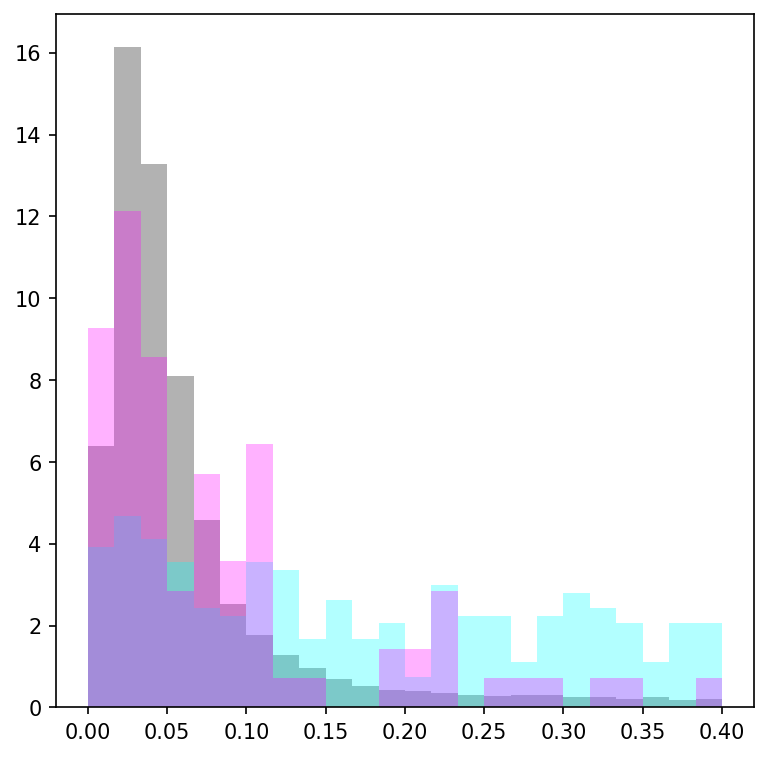

In [101]:
fig, ax = plt.subplots(figsize=(6,6), dpi=150)

ax.hist(hals['spin'], bins=np.linspace(0,0.4,25), density=True, alpha=0.3, fc='k', ec='none')
sample = allsubs[allsubs['mvir'] < 1e10]
ax.hist(sample['spin'], bins=np.linspace(0,0.4,25), density=True, alpha=0.3, fc='cyan', ec='none')
sample = allsubs[allsubs['mvir'] > 1e10]
ax.hist(sample['spin'], bins=np.linspace(0,0.4,25), density=True, alpha=0.3, fc='magenta', ec='none')
# # Dink
# color='tomato'
# mask = states=='dink'
# sample = allsubs[mask]
# L = np.sqrt( sample['Lx']**2 + sample['Ly']**2 + sample['Lz']**2 ) / sample['m']
# ax.hist(sample['spin'], bins=np.linspace(0,0.4,30), density=True, alpha=0.3, ec=color, fc='none', label='Dink')

# # Pair
# color='dodgerblue'
# mask = states=='pair'
# sample = allsubs[mask]
# L = np.sqrt( sample['Lx']**2 + sample['Ly']**2 + sample['Lz']**2 ) / sample['m']
# ax.hist(sample['spin'], bins=np.linspace(0,0.4,30), density=True, alpha=0.3, ec=color, fc='none', label='Pair')

# # UDG
# color='forestgreen'
# mask = states=='upair'
# sample = allsubs[mask]
# L = np.sqrt( sample['Lx']**2 + sample['Ly']**2 + sample['Lz']**2 ) / sample['m']
# ax.hist(sample['spin'], bins=np.linspace(0,0.4,30), density=True, alpha=0.3, ec=color, fc='none', label='UDGs')

plt.show()

No special.. but subhalos do not follow the PDF?

# Host or Sub?

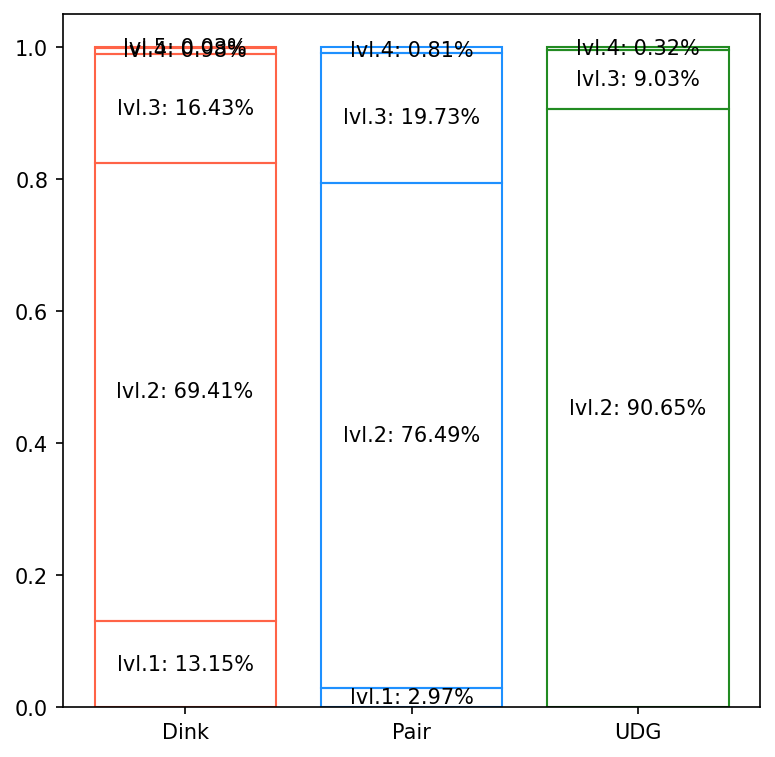

In [102]:
fig, ax = plt.subplots(figsize=(6,6), dpi=150)

# Dink
color='tomato'
mask = states=='dink'
sample = allsubs[mask]
unique, counts = np.unique(sample['level'], return_counts=True)
counts = counts/np.sum(counts)
bottom = 0
for uni, cou in zip(unique, counts):
    p=ax.bar("Dink", cou, ec=color, fc='none', bottom=bottom)
    ax.bar_label(p, label_type='center', fmt=f'lvl.{uni}: {100*cou:.2f}%')
    bottom += cou

# Pair
color='dodgerblue'
mask = states=='pair'
sample = allsubs[mask]
unique, counts = np.unique(sample['level'], return_counts=True)
counts = counts/np.sum(counts)
bottom = 0
for uni, cou in zip(unique, counts):
    p=ax.bar("Pair", cou, ec=color, fc='none', bottom=bottom)
    ax.bar_label(p, label_type='center', fmt=f'lvl.{uni}: {100*cou:.2f}%')
    bottom += cou

# UDG
color='forestgreen'
mask = states=='upair'
sample = allsubs[mask]
unique, counts = np.unique(sample['level'], return_counts=True)
counts = counts/np.sum(counts)
bottom = 0
for uni, cou in zip(unique, counts):
    p=ax.bar("UDG", cou, ec=color, fc='none', bottom=bottom)
    ax.bar_label(p, label_type='center', fmt=f'lvl.{uni}: {100*cou:.2f}%')
    bottom += cou

IndexError: index 3 is out of bounds for axis 0 with size 3

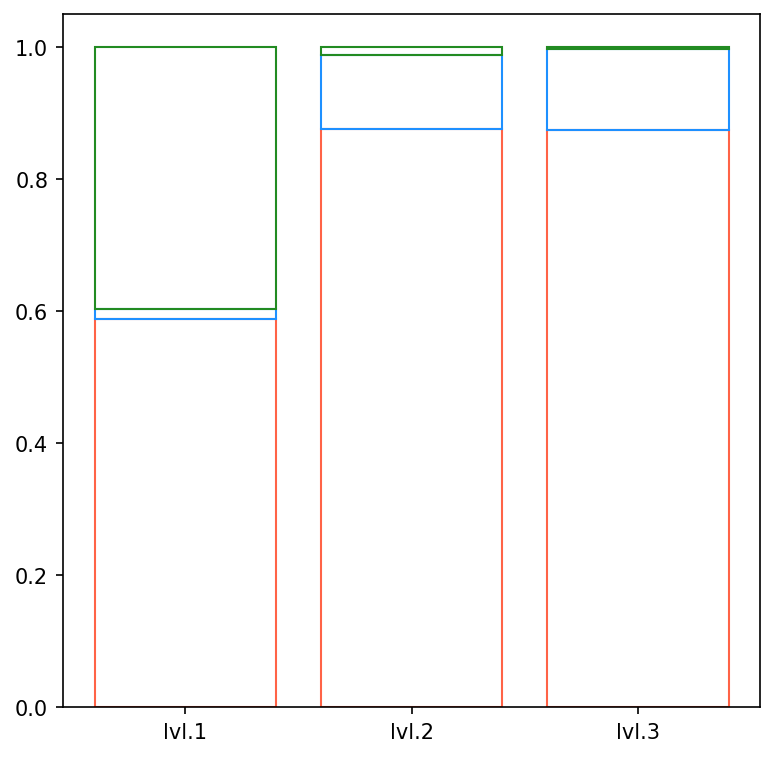

In [103]:
fig, ax = plt.subplots(figsize=(6,6), dpi=150)

# Dink
color='tomato'
mask = states=='dink'
sample = allsubs[mask]
unique0, counts0 = np.unique(sample['level'], return_counts=True)

# Pair
color='dodgerblue'
mask = states=='pair'
sample = allsubs[mask]
unique1, counts1 = np.unique(sample['level'], return_counts=True)

# UDG
color='forestgreen'
mask = states=='upair'
sample = allsubs[mask]
unique2, counts2 = np.unique(sample['level'], return_counts=True)

for i in range(5):
    lvl = i+1
    bottom = 0
    total = counts0[i] + counts1[i] + counts2[i]
    f = counts0[i]/total
    p=ax.bar(f"lvl.{lvl}", f, ec='tomato', fc='none', bottom=bottom); bottom += f
    f = counts1[i]/total
    p=ax.bar(f"lvl.{lvl}", f, ec='dodgerblue', fc='none', bottom=bottom); bottom += f
    f = counts2[i]/total
    p=ax.bar(f"lvl.{lvl}", f, ec='forestgreen', fc='none', bottom=bottom); bottom += f

In [104]:
counts, counts.type

AttributeError: 'numpy.ndarray' object has no attribute 'type'